<a href="https://colab.research.google.com/github/PochkaChaiki/gasReserves/blob/main/GasReservesCalculations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [341]:
# !pip install ipdb

In [342]:
import pdb
%pdb on

Automatic pdb calling has been turned ON


## Imports

In [343]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import scipy.stats as st
import scipy.optimize as so
from matplotlib import pyplot as plt
import seaborn as sns

In [344]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

Constants

In [345]:
zero_c_to_k = 273
norm_temp_c = 20
pres_std_cond = 0.101325 * 1e6

## Initial data

In [346]:
amount_of_vars = 3000

In [347]:
df_init_data = pd.DataFrame(columns=['area', 'effective_thickness', 'porosity_coef', 'gas_saturation_coef', 'init_reservoir_pressure',
                                     'relative_density', 'reservoir_temp', 'permeability'],
                            index=['value', 'min', 'max'])

df_init_data['area']                       = {"value":38_556 * 1e3, "min":36_628.20 * 1e3 , "max":40_483.80 * 1e3}
df_init_data['effective_thickness']        = {"value":11.10,   "min":10.50,     "max":12.15}
df_init_data['porosity_coef']              = {"value":0.091,    "min":0.0067,      "max":0.1278}
df_init_data['gas_saturation_coef']        = {"value":0.7,     "min":0.65,      "max":0.75}
df_init_data['init_reservoir_pressure']    = {"value":32.30 * 1e6,   "min":29.07 * 1e6,     "max":35.53 * 1e6}
df_init_data['relative_density']           = {"value":0.6348,    "min":0.6267,      "max":0.6429}
df_init_data['reservoir_temp']             = {"value":320.49,  "min":288.44,    "max":352.54}
df_init_data['permeability']               = {"value":0.75,    "min":0.002,         "max":19.14}

In [348]:
df_init_data

,area,effective_thickness,porosity_coef,gas_saturation_coef,init_reservoir_pressure,relative_density,reservoir_temp,permeability
value,38556000.0,11.10,0.0910,0.70,32300000.0,0.6348,320.49,0.750
min,36628200.0,10.50,0.0067,0.65,29070000.0,0.6267,288.44,0.002
max,40483800.0,12.15,0.1278,0.75,35530000.0,0.6429,352.54,19.140


## Results

In [349]:
df_result_data = pd.DataFrame(columns=['area_volume', 'pore_volume', 'temp_correction', 'fin_reservoir_pressure',
                                       'critical_pressure', 'critical_temp', 'init_overcompress_coef',
                                       'fin_overcompress_coef', 'geo_gas_reserves', 'dry_gas_init_reserves'],
                              index=['value', 'min', 'max'])

df_result_data['area_volume']            = df_init_data['area'] * df_init_data['effective_thickness']
df_result_data['pore_volume']            = df_result_data['area_volume'] * df_init_data['porosity_coef']
df_result_data['temp_correction']        = (zero_c_to_k * 2 + norm_temp_c) / (zero_c_to_k + df_init_data['reservoir_temp'] )
df_result_data['fin_reservoir_pressure'] = np.exp(1293 * 1e-9 * 2700 * df_init_data['relative_density']) # What are this magical numbers?
df_result_data['critical_pressure']      = (4.892 - 0.4048 * df_init_data['relative_density']) * 1e6 # Same question
df_result_data['critical_temp']          = 94.717 + 170.8 * df_init_data['relative_density'] # Same question
df_result_data['init_overcompress_coef'] = (0.4 * np.log10(df_init_data['reservoir_temp'] / df_result_data['critical_temp']) + 0.73)**(df_init_data['init_reservoir_pressure'] / df_result_data['critical_pressure']) + 0.1 * df_init_data['init_reservoir_pressure'] / df_result_data['critical_pressure'] # Same question
df_result_data['fin_overcompress_coef']  = (0.4 * np.log10(df_init_data['reservoir_temp'] / df_result_data['critical_temp']) + 0.73)**(df_result_data['fin_reservoir_pressure'] / df_result_data['critical_pressure']) + 0.1 * df_result_data['fin_reservoir_pressure'] / df_result_data['critical_pressure'] # Same question
df_result_data['geo_gas_reserves']       = df_init_data['area'] * df_init_data['effective_thickness'] * df_init_data['porosity_coef'] * df_init_data['gas_saturation_coef'] * df_init_data['init_reservoir_pressure'] / df_result_data['init_overcompress_coef'] / pres_std_cond * df_result_data['temp_correction']

df_result_data['dry_gas_init_reserves']  = df_result_data['geo_gas_reserves'] * (100 - 0.012 - 0.003 - 0.012) / 100 # You're kidding me! Same question
df_result_data

,area_volume,pore_volume,temp_correction,fin_reservoir_pressure,critical_pressure,critical_temp,init_overcompress_coef,fin_overcompress_coef,geo_gas_reserves,dry_gas_init_reserves
value,427971600.0,3.894542e+07,0.953681,1.002219,4635032.96,203.14084,0.925583,1.0,8.954221e+09,8.951803e+09
min,384596100.0,2.576794e+06,1.008122,1.002190,4638311.84,201.75736,0.858788,1.0,5.640901e+08,5.639378e+08
max,491878170.0,6.286203e+07,0.904818,1.002247,4631754.08,204.52432,0.994840,1.0,1.503614e+10,1.503208e+10


In [350]:
df_stat_params = pd.DataFrame(columns=['area', 'effective_thickness', 'porosity_coef', 'gas_saturation_coef', 'permeability'],
                            index=['distribution', 'params'])
df_stat_params['area'] = {'distribution': 'norm', 'params': {'mean': 38556 * 1e3, 'sigma': 3650 * 1e3}}
df_stat_params['effective_thickness'] = {'distribution': 'norm', 'params': {'mean': 11.10, 'sigma': 0.867}}
df_stat_params['porosity_coef'] = {'distribution': 'norm', 'params': {'mean': 0.09, 'sigma': 0.013}}
df_stat_params['gas_saturation_coef'] = {'distribution': 'norm', 'params': {'mean': 0.7, 'sigma': 0.01}}
df_stat_params['permeability'] = {'distribution': 'norm', 'params': {'mean': 9.569, 'sigma': 6.766}}

#First

## Statistic

In [351]:
df_stat_data = pd.DataFrame(columns=['area', 'effective_thickness', 'porosity_coef', 'gas_saturation_coef'])

for var in df_stat_data.columns:
    loc, scale = tuple(df_stat_params[var]['params'].values())
    # lb, rb = (df_init_data[var]['min'] - loc) / scale, (df_init_data[var]['max'] - loc) / scale
    # df_stat_data[var] = st.truncnorm.rvs(lb, rb, loc=loc, scale=scale, size=amount_of_vars)
    df_stat_data[var] = st.norm.rvs(loc=loc, scale=scale, size=amount_of_vars)

In [352]:
# area                = st.truncnorm.rvs(*(df_init_data['area']['min'], df_init_data['area']['max'], *tuple(df_stat_params['area']['params'].values()), amount_of_vars))

In [353]:
reserves = df_stat_data.prod(axis=1) * df_init_data['init_reservoir_pressure']['value'] * df_result_data['temp_correction']['value'] / df_result_data['init_overcompress_coef']['value'] / pres_std_cond

In [354]:
fig = make_subplots(rows=1, cols=5)
for var, i in zip(df_stat_data.columns, range(1,6)):
    fig.add_trace(
        go.Histogram(x=df_stat_data[var], nbinsx=14), row=1, col=i)

fig.add_trace(go.Histogram(x=reserves, nbinsx=14), row=1, col=5)
fig

### Params sensitivity

In [355]:
df_sens = pd.DataFrame(dict(min=df_stat_data.min(), mean=df_stat_data.mean(), max=df_stat_data.max()))
df_sens

,min,mean,max
area,2.648151e+07,3.840005e+07,5.239697e+07
effective_thickness,7.908374e+00,1.108084e+01,1.385541e+01
porosity_coef,4.811109e-02,8.962770e-02,1.327616e-01
gas_saturation_coef,6.654047e-01,7.000763e-01,7.341712e-01


In [356]:
const_multiplier = df_init_data['init_reservoir_pressure']['value'] * df_result_data['temp_correction']['value'] / df_result_data['init_overcompress_coef']['value'] / pres_std_cond

In [357]:
df_reserves_affection = pd.DataFrame(columns=['min', 'max'], index=df_sens.index)
for var in df_sens.index:
    df_reserves_affection['min'][var] = reserves.mean() - df_sens['min'][var] * df_sens.loc[df_sens.index != var]['mean'].prod() * const_multiplier
    df_reserves_affection['max'][var] = df_sens['max'][var] * df_sens.loc[df_sens.index != var]['mean'].prod() * const_multiplier - reserves.mean()
df_reserves_affection

,min,max
area,2719955456.461213,3198283845.990076
effective_thickness,2508822631.45244,2197624043.884964
porosity_coef,4060200847.953979,4222130313.182383
gas_saturation_coef,432456882.603259,428927481.905941


In [358]:
df_affection = pd.DataFrame(dict(
    kmin=df_reserves_affection['min']/df_reserves_affection['min'].sum(),
    kmax=abs(df_reserves_affection['max'])/df_reserves_affection['max'].sum()
))
df_affection

,kmin,kmax
area,0.279789,0.318333
effective_thickness,0.258071,0.218735
porosity_coef,0.417654,0.420239
gas_saturation_coef,0.044485,0.042692


In [359]:
fig2 = make_subplots(rows=1,cols=2)
fig2.add_trace(
    go.Bar(
        x=df_affection['kmin'],
        y=df_affection.index,
        orientation='h',
        name='Влияние в меньшую сторону',
        ),
    row=1,
    col=1
)
fig2.add_trace(
    go.Bar(
        x=df_affection['kmax'],
        y=df_affection.index,
        orientation='h',
        name='Влияние в большую сторону',
        ),
    row=1,
    col=2
)

fig2.update_layout(
    xaxis=dict(
        domain=[0.0, 0.5],
        autorange="reversed"
    ),
    xaxis2=dict(domain=[0.5, 1]),
    yaxis=dict(ticklabelstandoff=15),
    yaxis2=dict(visible=False),
    legend=dict(
        orientation='h',
        xanchor='center',
        x=0.5
    )
)


annotations=[]

# Adding labels
for ykmin, ykmax, xd in zip(df_affection['kmin'], df_affection['kmax'], df_affection.index):
    # labeling the bar net worth
    annotations.append(dict(xref='x1', yref='y1',
                            y=xd, x=ykmin+0.03,
                            text=str(np.round(ykmin*100, 1)) + '%',
                            showarrow=False))
    annotations.append(dict(xref='x2', yref='y2',
                            y=xd, x=ykmax+0.03,
                            text=str(np.round(ykmax*100, 1)) + '%',
                            showarrow=False))

fig2.update_layout(annotations=annotations)
fig2

### P10, P50, P90

In [360]:
p10 = st.norm.ppf(0.9, loc=reserves.mean(), scale=reserves.std())
p50 = st.norm.ppf(0.5, loc=reserves.mean(), scale=reserves.std())
p90 = st.norm.ppf(0.1, loc=reserves.mean(), scale=reserves.std())
p90, p50, p10

(6636938088.705026, 8767463409.282959, 10897988729.860891)

In [361]:
df_prob_estimates = pd.DataFrame(dict(
    p90=st.norm.ppf(0.1, loc=df_stat_data.mean(), scale=df_stat_data.std()),
    p50=st.norm.ppf(0.5, loc=df_stat_data.mean(), scale=df_stat_data.std()),
    p10=st.norm.ppf(0.9, loc=df_stat_data.mean(), scale=df_stat_data.std()),
), index=df_stat_data.columns)
df_prob_estimates.loc["reserves"] = [p90, p50, p10]
df_prob_estimates

,p90,p50,p10
area,3.374041e+07,3.840005e+07,4.305969e+07
effective_thickness,9.955280e+00,1.108084e+01,1.220640e+01
porosity_coef,7.308864e-02,8.962770e-02,1.061668e-01
gas_saturation_coef,6.872598e-01,7.000763e-01,7.128928e-01
reserves,6.636938e+09,8.767463e+09,1.089799e+10


In [362]:
# fig3 = go.Figure()
fig3 = px.ecdf(reserves)
fig3.add_trace(go.Scatter(x=[p90, p50, p10], y=[0.1, 0.5, 0.9], mode='markers', marker_size=20))
fig3

# Second

## Development indicators

In [363]:
a = pd.DataFrame(dict( r = 12), index=['value'])
a.r+1

,r
value,13


In [364]:
permeability = abs(st.norm.rvs(loc=df_stat_params['permeability']['params']['mean'], scale=df_stat_params['permeability']['params']['sigma'], size=amount_of_vars))
permeability.mean(), permeability.std()

(10.051735439813921, 6.116664627417927)

In [365]:
permeability_p10 = st.norm.ppf(0.9, loc=permeability.mean(), scale=permeability.std())
permeability_p50 = st.norm.ppf(0.5, loc=permeability.mean(), scale=permeability.std())
permeability_p90 = st.norm.ppf(0.1, loc=permeability.mean(), scale=permeability.std())
permeability_p10, permeability_p50, permeability_p90

(17.890556568992643, 10.051735439813921, 2.212914310635197)

### Parameters for evaluation

In [366]:
init_pressure = df_init_data['init_reservoir_pressure']['value'] / 10**6
reservoir_temp = df_init_data['reservoir_temp']['value']
relative_density = df_init_data['relative_density']['value']
init_overcompress_coef = df_result_data['init_overcompress_coef']['value'] # 0.94
max_depression = 2 * 1e6 / 10**6
required_whole_gas_production = 12 * 1e7 / 10**6
reserve_ratio = 1.05
operations_ratio = 0.98
porosity_coef = df_init_data['porosity_coef']['value']
gas_saturation_coef = 0.72                             # alpha
avg_well_temp = (reservoir_temp + 293) / 2
pipe_diameter = 0.114
well_height = 2700
pipe_roughness = 0.0001
init_num_wells = 1
trail_length = 2300
trail_diameter = 0.168
trail_roughness = 0.0001
avg_trail_temp = 323.15
main_gas_pipeline_pressure = 4 * 1e6 / 10**6
input_cs_temp = 310
coef_K = 3326400
efficiency_cs = 0.87
adiabatic_index = 1.3
density_athmospheric = relative_density * 28.96 / 22.4
viscosity = 0.012

lambda_trail = 0.067 * (2 * trail_roughness / trail_diameter)**0.2

In [367]:
lambda_fontain = (2 * np.log10(7.41 * pipe_diameter/ 2 / pipe_roughness))**(-2)

Depends on dev indics mode:

In [368]:
effective_thickness = df_prob_estimates['p50']['effective_thickness']
geo_gas_reserves = df_prob_estimates['p10']['reserves'] / 10**6
annual_production = geo_gas_reserves * 0.045
permeability_k = permeability_p50
macro_roughness_l = 0.425 * 1e-9 * permeability_k ** 1.45 /100
filtr_resistance_A = viscosity *  init_overcompress_coef * 0.1013 * reservoir_temp / (np.pi * permeability_k * effective_thickness * 293.15) * np.log(500/0.1) * 11.347 * 1e3
filtr_resistance_B = density_athmospheric * 0.1013 *  init_overcompress_coef * reservoir_temp / macro_roughness_l / (2 * np.pi**2 *  effective_thickness**2 * 293.15) * (1/0.1 - 1/500) * 10**(-6) / 86400**2 * 1e3

In [369]:
annual_production, geo_gas_reserves

(490.4094928437401, 10897.988729860892)

In [370]:
filtr_resistance_A, filtr_resistance_B, macro_roughness_l

(0.33973852276355004, 3.8522031830751213e-07, 1.2068087540390897e-10)

Initial values of varying parameters

In [371]:
year = [0]
current_annual_production = 0
sum_current_annual_production = 0
current_pressure = init_pressure
overcompress_coef = init_overcompress_coef

In [372]:
kig = 0
current_daily_production = 0
downhole_pressure = current_pressure - max_depression

s = 0
overcomp_coef_avg = 0
theta = 0

n_wells = 0

machines_num = 1
time_to_build = 6


In [373]:
list_annual_production = []
list_current_pressure = []
list_overcompress_coef = []
list_daily_production = []
list_n_wells = []
list_kig = []
list_wellhead_pressure = []

list_ukpg_pressure = []
list_cs_power = []

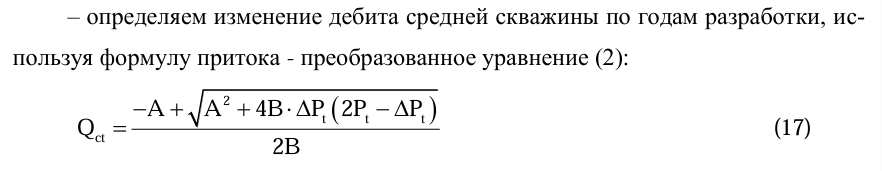

In [374]:
def count_daily_production(x):
    return (-filtr_resistance_A + np.sqrt(filtr_resistance_A**2 + 4 * filtr_resistance_B * max_depression * (2*x - max_depression))) / 2 / filtr_resistance_B

In [375]:
def count_overcomp_coef(x, temp):
    return (0.4 * np.log10(temp / df_result_data['critical_temp'].value) + 0.73)**(x / df_result_data['critical_pressure'].value * 1e6) + 0.1 * x / df_result_data['critical_pressure'].value * 1e6

In [376]:
while (kig < 0.5):

    if current_daily_production * n_wells * operations_ratio * 365 / 1000 <= annual_production:
        n_wells += np.trunc(12 / (machines_num * time_to_build))


    def func(x):
        return [init_pressure / init_overcompress_coef * (1 - sum_current_annual_production / geo_gas_reserves) * x[1] - x[0],
                count_overcomp_coef(x[0], reservoir_temp) - x[1],
                sum_current_annual_production + 365 * n_wells * operations_ratio * count_daily_production(x[0]) / 1000 - x[2]]

    current_pressure, overcompress_coef, _ = so.fsolve(func, [current_pressure, overcompress_coef, sum_current_annual_production], xtol=1e-3)
    # current_pressure, overcompress_coef = so.broyden1(func, [current_pressure, overcompress_coef], f_tol=1e-1, verbose=True)
    current_daily_production = count_daily_production(current_pressure)

    if (current_pressure - max_depression > 0):
        downhole_pressure = current_pressure - max_depression
    else:
        downhole_pressure = 0;

    s = 0.03415 * relative_density * well_height / overcompress_coef / avg_well_temp
    # using Pt instead of Pcp --->
    overcomp_coef_avg = count_overcomp_coef(current_pressure, avg_well_temp)
    theta = 0.0132 * 10**(-10) * lambda_fontain * overcomp_coef_avg**2 * avg_well_temp**2 * (np.exp(2 * s) - 1) / pipe_diameter**5

    if downhole_pressure > 0:
        wellhead_pressure = np.sqrt((downhole_pressure**2 - theta * current_daily_production**2) / np.exp(2 * s))
    else:
        wellhead_pressure = 0


    if 365 * current_daily_production * n_wells * operations_ratio / 1000 > annual_production:
        current_annual_production = annual_production
    else:
        current_annual_production = 365 * current_daily_production * n_wells * operations_ratio / 1000

    ukpg_pressure = np.sqrt(wellhead_pressure**2 - lambda_trail * relative_density * \
    count_overcomp_coef(2/3 * (downhole_pressure + wellhead_pressure**2 / (downhole_pressure + wellhead_pressure)), avg_well_temp)\
    * avg_trail_temp * trail_length * (current_daily_production * n_wells)**2 / trail_diameter**5 / coef_K**2 )

    power = 0
    if ukpg_pressure < main_gas_pipeline_pressure:
        power = 0.004 * current_daily_production * n_wells * input_cs_temp * \
          count_overcomp_coef(ukpg_pressure, input_cs_temp) / \
          efficiency_cs * adiabatic_index / (adiabatic_index - 1) * \
          ((main_gas_pipeline_pressure/ukpg_pressure)**((adiabatic_index - 1) / adiabatic_index) - 1)

    sum_current_annual_production += current_annual_production
    kig = sum_current_annual_production / geo_gas_reserves

    list_kig.append(kig)
    list_annual_production.append(current_annual_production)
    list_current_pressure.append(current_pressure)
    list_n_wells.append(n_wells)
    list_wellhead_pressure.append(wellhead_pressure)
    list_ukpg_pressure.append(ukpg_pressure)
    list_cs_power.append(power)

    year.append(year[-1]+1)

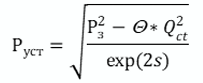

In [377]:
firstLoopResults = pd.DataFrame(dict(kig = list_kig, annual_production = list_annual_production, current_pressure = list_current_pressure, wellhead_pressure = list_wellhead_pressure, n_wells = list_n_wells))

In [378]:
firstLoopResults

,kig,annual_production,current_pressure,wellhead_pressure,n_wells
0,0.024181,263.528210,32.300000,24.560422,2.0
1,0.069181,490.409493,31.062753,23.487200,4.0
2,0.112361,470.571774,28.944328,21.668703,4.0
3,0.157361,490.409493,27.093075,20.099749,6.0
4,0.202361,490.409493,25.312792,18.608892,6.0
5,0.247361,490.409493,23.655669,17.237025,6.0
6,0.292361,490.409493,22.095342,15.958497,6.0
7,0.337361,490.409493,20.615159,14.757088,6.0
8,0.379551,459.789215,19.200314,13.618403,6.0
9,0.424551,490.409493,17.922150,12.597099,8.0


Not finished ---V!!!

In [379]:
while current_pressure > 0.05 * init_pressure and wellhead_pressure>0.1:


    def func(x):
        return [init_pressure / init_overcompress_coef * (1 - x[2] / geo_gas_reserves) * x[1] - x[0],
                count_overcomp_coef(x[0], reservoir_temp) - x[1],
                sum_current_annual_production + 365 * n_wells * operations_ratio * (current_daily_production + count_daily_production(x[0])) / (2 * 10**6 * reserve_ratio) *1e3 - x[2]]

    # current_pressure, overcompress_coef = so.fsolve(func, [current_pressure, overcompress_coef], xtol=1e-1)
    current_pressure, overcompress_coef, _ = so.newton_krylov(func, [current_pressure, overcompress_coef, sum_current_annual_production], f_tol=1e-1, verbose=True)
    new_current_daily_production = count_daily_production(current_pressure)

    if (current_pressure - max_depression > 0):
        downhole_pressure = current_pressure - max_depression
    else:
        downhole_pressure = 0

    s = 0.03415 * relative_density * well_height / overcompress_coef / avg_well_temp
    overcomp_coef_avg = count_overcomp_coef(current_pressure, avg_well_temp)
    theta = 0.0132 * 10**(-10) * lambda_fontain * overcomp_coef_avg**2 * avg_well_temp**2 * (np.exp(2*s) - 1) / pipe_diameter**5

    if downhole_pressure > 0:
        wellhead_pressure = np.sqrt((downhole_pressure**2 - theta * new_current_daily_production**2) / np.exp(2 * s))
    else:
        wellhead_pressure = 0

    current_annual_production = 365 * n_wells * operations_ratio / (2 * 10**6 * reserve_ratio) * (new_current_daily_production + current_daily_production) * 1e3
    current_daily_production = new_current_daily_production

    sum_current_annual_production += current_annual_production
    kig = sum_current_annual_production / geo_gas_reserves

    ukpg_pressure = np.sqrt(wellhead_pressure**2 - lambda_trail * relative_density * \
    count_overcomp_coef(2/3 * (downhole_pressure + wellhead_pressure**2 / (downhole_pressure + wellhead_pressure)), avg_well_temp)\
    * avg_trail_temp * trail_length * (current_daily_production * n_wells)**2 / trail_diameter**5 / coef_K**2 )

    power = 0
    if ukpg_pressure < main_gas_pipeline_pressure:
        power = 0.004 * current_daily_production * n_wells * input_cs_temp * \
          count_overcomp_coef(ukpg_pressure, input_cs_temp) / \
          efficiency_cs * adiabatic_index / (adiabatic_index - 1) * \
          ((main_gas_pipeline_pressure/ukpg_pressure)**((adiabatic_index - 1) / adiabatic_index) - 1)

    list_annual_production.append(current_annual_production)
    list_current_pressure.append(current_pressure)
    # list_daily_production.append(current_daily_production)
    list_n_wells.append(n_wells)
    # list_overcompress_coef.append(overcompress_coef)
    list_wellhead_pressure.append(wellhead_pressure)
    year.append( year[-1]+ 1)

    list_ukpg_pressure.append(ukpg_pressure)
    list_cs_power.append(power)
    list_kig.append(kig)

0:  |F(x)| = 0.100566; step 1
1:  |F(x)| = 1.38803e-05; step 1
0:  |F(x)| = 0.00415589; step 1
0:  |F(x)| = 0.0046771; step 1
0:  |F(x)| = 0.033252; step 1
0:  |F(x)| = 0.00987056; step 1
0:  |F(x)| = 0.00569123; step 1
0:  |F(x)| = 0.0154313; step 1
0:  |F(x)| = 0.0231614; step 1
0:  |F(x)| = 0.00936822; step 1
0:  |F(x)| = 0.00589384; step 1
0:  |F(x)| = 0.0212486; step 1
0:  |F(x)| = 0.011767; step 1
0:  |F(x)| = 0.0117616; step 1
0:  |F(x)| = 0.00538575; step 1
0:  |F(x)| = 0.00519559; step 1
0:  |F(x)| = 0.00498947; step 1
0:  |F(x)| = 0.00477114; step 1
0:  |F(x)| = 0.00454511; step 1
0:  |F(x)| = 0.00431399; step 1
0:  |F(x)| = 0.00408076; step 1
0:  |F(x)| = 0.00384788; step 1
0:  |F(x)| = 0.00361735; step 1
0:  |F(x)| = 0.00339139; step 1
0:  |F(x)| = 0.00317127; step 1
0:  |F(x)| = 0.00295826; step 1
0:  |F(x)| = 0.00275333; step 1
0:  |F(x)| = 0.00255721; step 1
0:  |F(x)| = 0.00237035; step 1
0:  |F(x)| = 0.00219322; step 1


<ipython-input-379-77e233abecc1>:33: RuntimeWarning:

invalid value encountered in sqrt

<ipython-input-379-77e233abecc1>:23: RuntimeWarning:

invalid value encountered in sqrt



In [380]:
secondLoopResults = pd.DataFrame(dict(kig = list_kig, annual_production = list_annual_production, current_pressure = list_current_pressure, wellhead_pressure = list_wellhead_pressure, n_wells = list_n_wells, ukpg_pressure = list_ukpg_pressure, cs_power = list_cs_power))

In [381]:
secondLoopResults

,kig,annual_production,current_pressure,wellhead_pressure,n_wells,ukpg_pressure,cs_power
0,0.024181,263.528210,32.300000,24.560422,2.0,24.507427,0.000000
1,0.069181,490.409493,31.062753,23.487200,4.0,23.284348,0.000000
2,0.112361,470.571774,28.944328,21.668703,4.0,21.481946,0.000000
3,0.157361,490.409493,27.093075,20.099749,6.0,19.707500,0.000000
4,0.202361,490.409493,25.312792,18.608892,6.0,18.244498,0.000000
5,0.247361,490.409493,23.655669,17.237025,6.0,16.897575,0.000000
6,0.292361,490.409493,22.095342,15.958497,6.0,15.641761,0.000000
7,0.337361,490.409493,20.615159,14.757088,6.0,14.461300,0.000000
8,0.379551,459.789215,19.200314,13.618403,6.0,13.342175,0.000000
9,0.424551,490.409493,17.922150,12.597099,8.0,12.133048,0.000000


In [382]:
fig_pressure = go.Figure()
fig_pressure.add_trace(go.Scatter(x=secondLoopResults.index.values.tolist(), y=secondLoopResults["current_pressure"], mode="lines+markers", name="Pt"))
fig_pressure.add_trace(go.Scatter(x=secondLoopResults.index.values.tolist(), y=secondLoopResults["wellhead_pressure"], mode="lines+markers", name="Pуcт"))
fig_pressure.add_trace(go.Scatter(x=secondLoopResults.index.values.tolist(), y=secondLoopResults["current_pressure"]-max_depression, mode="lines+markers", name="Pзаб"))
fig_pressure.add_trace(go.Scatter(x=secondLoopResults.index.values.tolist(), y=secondLoopResults["ukpg_pressure"], mode="lines+markers", name="Pукпг"))
fig_pressure

In [383]:
fig_production = make_subplots(specs=[[{"secondary_y": True}]])
fig_production.add_trace(go.Scatter(x=secondLoopResults.index.values.tolist(), y=secondLoopResults["annual_production"], mode="lines+markers", name="Qt"), secondary_y = False)
fig_production.add_trace(go.Scatter(x=secondLoopResults.index.values.tolist(), y=secondLoopResults["kig"], mode="lines+markers", name="kig"), secondary_y = True)
fig_production